Let's dig a little further into the XHMM results, generating the visualization plots and figuring out which genes are hit by our CNV findings. As usual, we'll follow guidelines from https://atgu.mgh.harvard.edu/xhmm/tutorial.shtml: (ran in terminal)

In [ ]:
%%bash

module load plinkseq
module load R

# this takes a little over 1h!
pseq . loc-intersect --group refseq --locdb /fdb/plinkseq/hg19/locdb \
    --file /data/NCR_SBRB/simplex/SeqCapEZ_Exome_v3.0_Design_Annotation_files/SeqCap_EZ_Exome_v3_hg19_capture_targets.bed \
    --out ./annotated_targets.refseq --noweb
    
Rscript example_make_XHMM_plots.R

But let's update what we were doing back in 11/21/2017 to only include CNVs that have genes in them.

In [3]:
import vcf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

In [6]:
# figure out who is who in each trio

import glob
data_dir = '/data/NCR_SBRB/simplex/'
trios = {}
affected = []
controls = []
peds = glob.glob(data_dir + '*trio*ped')
for ped in peds:
    trio_name = ped.split('/')[-1].split('.')[0]
    fid = open(ped, 'r')
    fam = {}
    for line in fid:
        famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
        if fa != '0':
            fam['child'] = sid
            if aff == '1':
                affected.append(trio_name)
            else:
                controls.append(trio_name)
        elif sex == '1':
            fam['father'] = sid
        else:
            fam['mother'] = sid
    trios[trio_name] = fam
    fid.close()
    
fid = open('/data/NCR_SBRB/simplex/famids.txt', 'r')
fams = [t.rstrip() for t in fid]
fid.close()

# CCGO_800976 was removed during sample filtering step in XHMM
del trios['10369_trio1']
del trios['10369_trio2']
fams.remove('10369')

In [45]:
# saving the important metrics from VCFs
vcf_reader = vcf.Reader(open('/data/NCR_SBRB/simplex/xhmm/DATA.vcf', 'r'))
SQs = {}
LQs = {}
RQs = {}
NQs = {}
cnv_start, cnv_end = [], []
for sample in vcf_reader.samples:
    SQs[sample] = []
    LQs[sample] = []
    RQs[sample] = []
    NQs[sample] = []
for record in vcf_reader:
    cnv_start.append(record.start)
    cnv_end.append(record.end)
    for sample in record.samples:
        SQs[sample.sample].append(sample.data.SQ)
        LQs[sample.sample].append(sample.data.LQ)
        RQs[sample.sample].append(sample.data.RQ)
        NQs[sample.sample].append(sample.data.NQ)

For the disruptive criteria, we'll need to know which records have start or end within a gene transcript:

In [65]:
annot = pd.read_table('/data/NCR_SBRB/simplex/xhmm/annotated_targets.refseq.loci',
                      names=['window', 'nannot', 'names'], header=None)
trans_start, trans_end = [], []
for pos, nannot in zip(annot.window, annot.nannot):
    if nannot > 0:
        start, end = pos.split(':')[-1].split('..')
        trans_start.append(int(start))
        trans_end.append(int(end))
trans_start = np.array(trans_start)
trans_end = np.array(trans_end)

left_transcript, right_transcript = [], []
for l, r in zip(cnv_start, cnv_end):
    left_transcript.append(np.any((trans_start < l) & (trans_end > l)))
    right_transcript.append(np.any((trans_start < r) & (trans_end > r)))
left_transcript = np.array(left_transcript)
right_transcript = np.array(right_transcript)

In [66]:
quality = np.arange(10, 100, 10)
ntrios = len(trios)
trans_rate = np.zeros([ntrios, len(quality)])
denovo = np.zeros([ntrios, len(quality)])
disruptive_dnm = np.zeros([ntrios, len(quality)])
disruptive_inh = np.zeros([ntrios, len(quality)])
cnvs = np.zeros([ntrios, len(quality)])
for q, qual in enumerate(quality):
    qual_prime = qual / 2.0
    for t, trio in enumerate(trios.keys()):
        some_deletion = np.any(np.array(SQs[trios[trio]['child']]) >= qual,
                               axis=1)
        cnvs[t, q] = np.sum(some_deletion)
        
        # denovo criteria
        mom_diploid = np.any(np.array(NQs[trios[trio]['mother']]) >= qual,
                             axis=1)
        dad_diploid = np.any(np.array(NQs[trios[trio]['father']]) >= qual,
                             axis=1)
        child_dnms = np.logical_and(some_deletion,
                                    np.logical_and(mom_diploid, dad_diploid))
        denovo[t, q] = np.sum(child_dnms)
        
        # transmitted criteria
        mom_deletion = np.any(np.array(SQs[trios[trio]['mother']]) >= qual,
                              axis=1)
        mom_source = np.logical_and(mom_deletion, dad_diploid)
        dad_deletion = np.any(np.array(SQs[trios[trio]['father']]) >= qual,
                              axis=1)
        dad_source = np.logical_and(dad_deletion, mom_diploid)
        transmitted = np.logical_or(np.logical_and(mom_source, some_deletion),
                                    np.logical_and(dad_source, some_deletion))
        
        child_diploid = np.any(np.array(NQs[trios[trio]['child']]) >= qual,
                               axis=1)
        not_transmitted = np.logical_or(np.logical_and(mom_source,
                                                       child_diploid),
                                        np.logical_and(dad_source,
                                                       child_diploid))
        trans_rate[t, q] = float(np.sum(transmitted)) / (np.sum(transmitted) +
                                                         np.sum(not_transmitted))
        
        # disruptive criteria
        good_left = np.any(np.array(LQs[trios[trio]['child']]) >= qual_prime,
                           axis=1)
        good_right = np.any(np.array(RQs[trios[trio]['child']]) >= qual_prime,
                            axis=1)
        in_gene = np.logical_and(np.logical_or(good_left, good_right),
                                 np.logical_or(left_transcript, right_transcript))
        idx = np.logical_and(child_dnms, in_gene)
        disruptive_dnm[t, q] = np.sum(idx)
        idx = np.logical_and(transmitted, in_gene)
        disruptive_inh[t, q] = np.sum(idx)

([<matplotlib.axis.XTick at 0x2aab1ac0f390>,
 <a list of 9 Text xticklabel objects>)

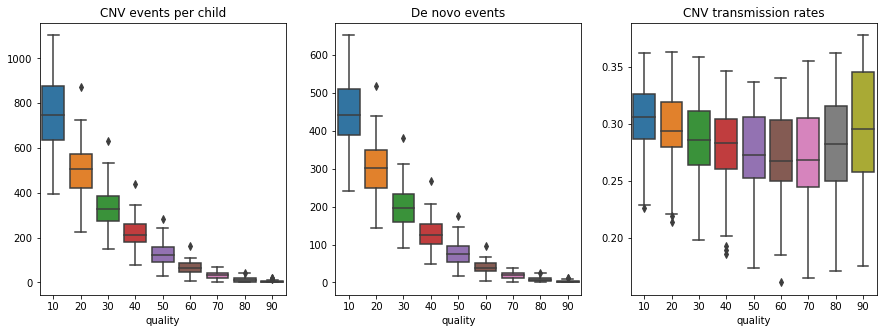

In [67]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(data=[disruptive_dnm[:, q] + disruptive_inh[:, q] for q in range(len(quality))], orient='v')
plt.xlabel('quality')
plt.title('CNV events per child')
plt.xticks(range(len(quality)), quality)

plt.subplot(1, 3, 2)
sns.boxplot(data=[disruptive_dnm[:, q] for q in range(len(quality))], orient='v')
plt.xlabel('quality')
plt.title('De novo events')
plt.xticks(range(len(quality)), quality)

plt.subplot(1, 3, 3)
sns.boxplot(data=[trans_rate[:, q] for q in range(len(quality))], orient='v')
plt.xlabel('quality')
plt.title('CNV transmission rates')
plt.xticks(range(len(quality)), quality)

In [68]:
quality = np.arange(10, 100, 10)
means = np.zeros([3, len(quality)])
for q, qual in enumerate(quality):
    aff = []
    unaff_pair = []
    unaff_all = []
    for fam in fams:
        # this family only has an affected trio
        if fam != '10042':
            keys = [k for k in trios.iterkeys() if k.find(fam)==0]
            keys.sort()
            k = [k for k in range(len(trios.keys())) if trios.keys()[k] == keys[0]]
            aff.append(disruptive_dnm[k[0], q])
            k = [k for k in range(len(trios.keys())) if trios.keys()[k] == keys[1]]
            unaff_pair.append(disruptive_dnm[k[0], q])
            for mykey in keys[1:]:
                k = [k for k in range(len(trios.keys())) if trios.keys()[k] == mykey]
                unaff_all.append(disruptive_dnm[k[0], q])
    means[0, q] = np.mean(aff)
    means[1, q] = np.mean(unaff_pair)
    means[2, q] = np.mean(unaff_all)

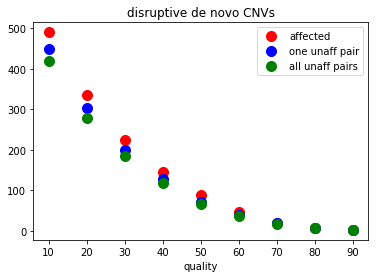

In [69]:
plt.figure()
plt.plot(quality, means[0, :], '.', color='r', markersize=20)
plt.plot(quality, means[1, :], '.', color='b', markersize=20)
plt.plot(quality, means[2, :], '.', color='g', markersize=20)
plt.legend(['affected', 'one unaff pair', 'all unaff pairs'])
plt.xlabel('quality')
plt.title('disruptive de novo CNVs')

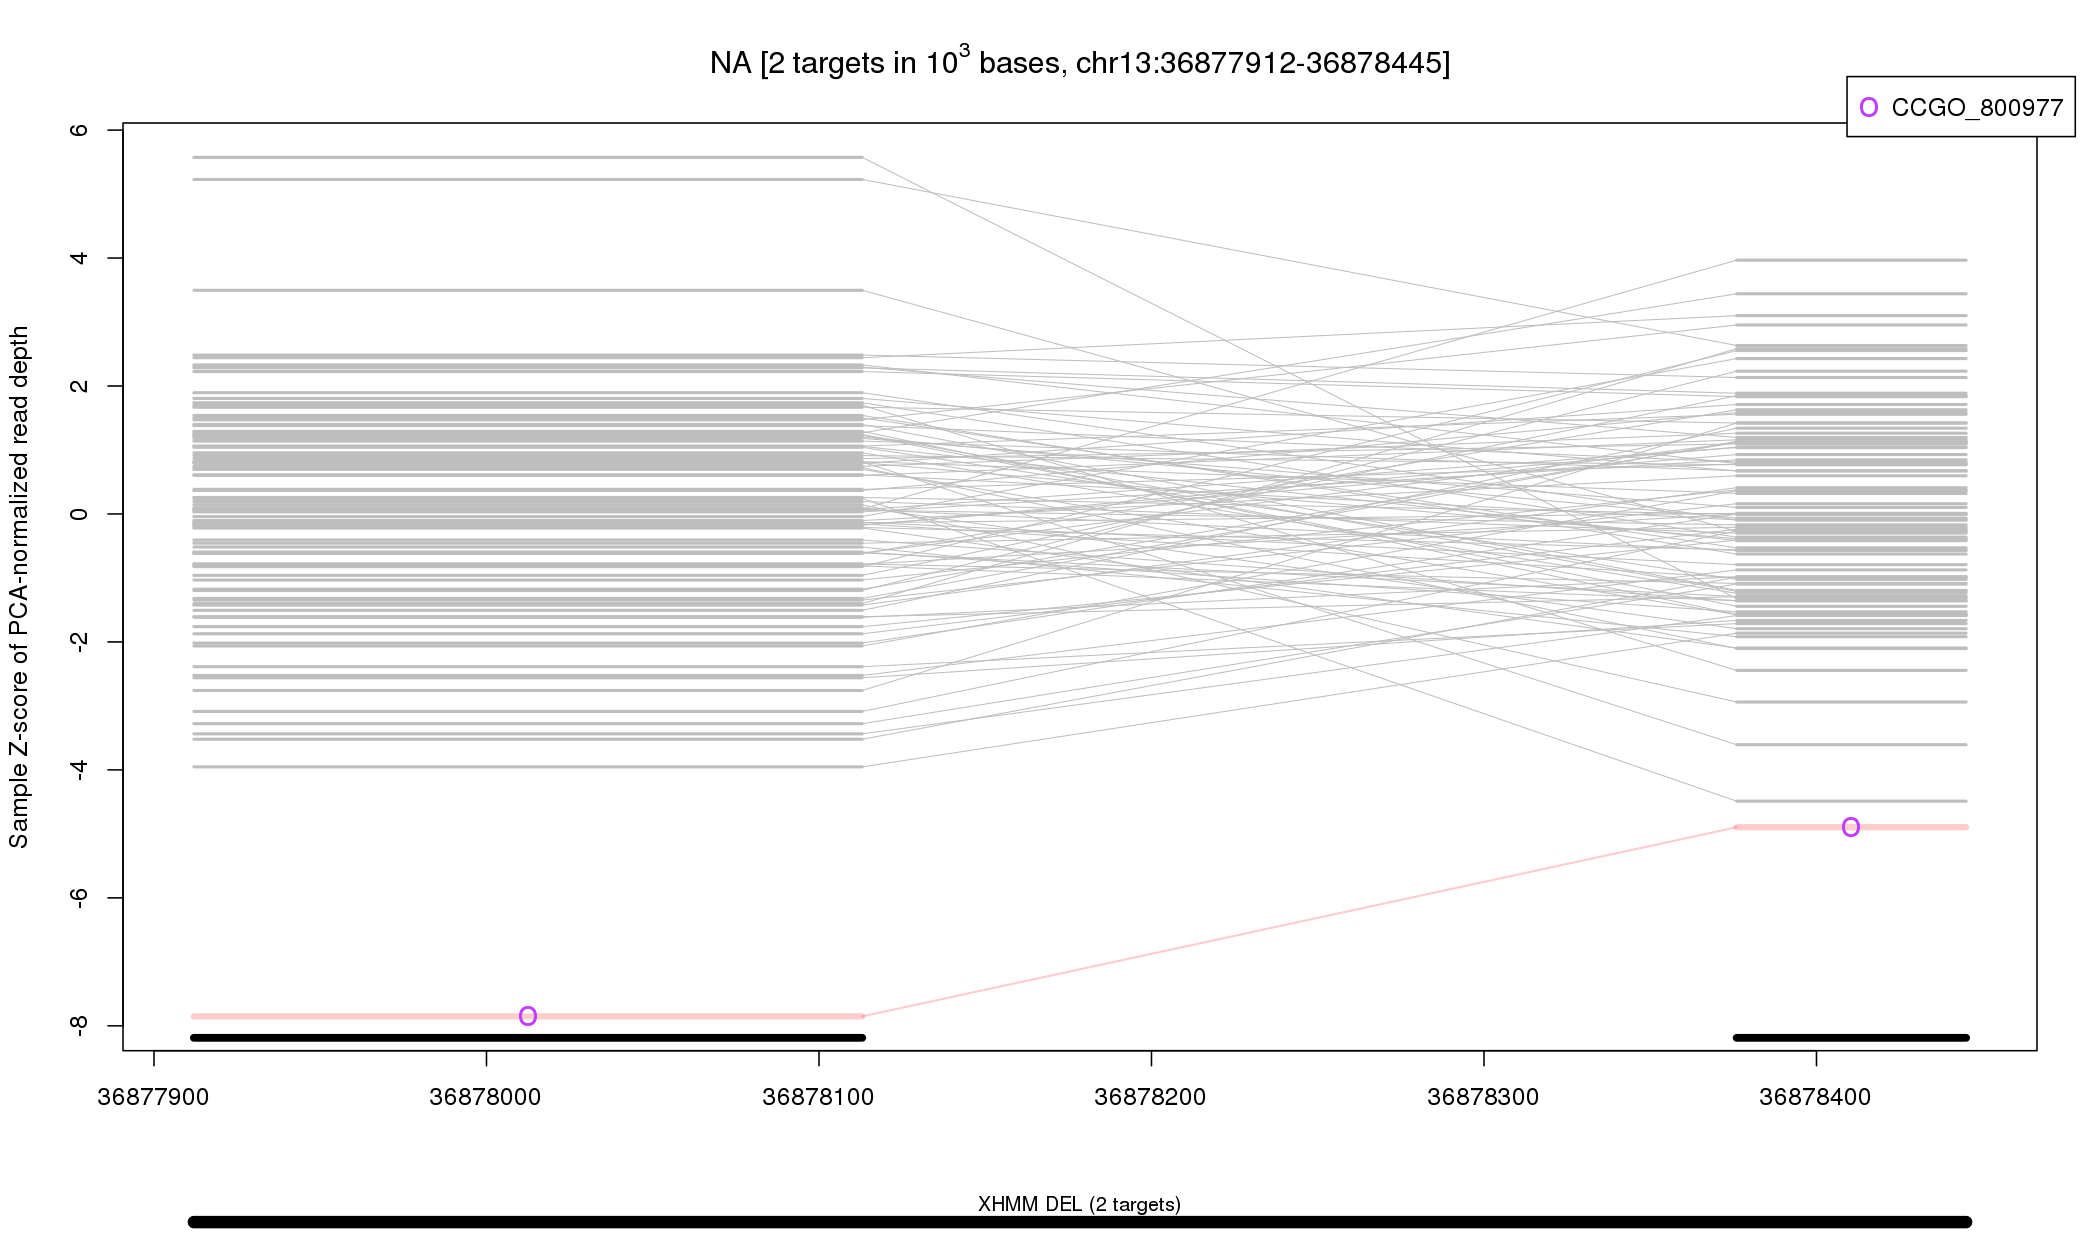

In [17]:
from IPython.display import display, Image

display(Image('/data/NCR_SBRB/simplex/xhmm/plots/plot_CNV/sample_CCGO_800977.chr13:36877912-36878445.SQ_41.exact.png'))

# TODO:

* look and understand the different figures
* make sure that the whole disruptive gene thingy is working properly (look at figures)
* better to run PCA within groups? are controls biasing the results? check literature. might need ot run other tools instead
* number of rare denovo CNVs present only in affected trio, and compare it to numbers only in unaffected trio!
* check different parameters in HMM to end up with less CNVs
* if we add the brain to this, instead of doing nv vs adhd contrast, could we do brain correlations?
* incorporate multiplex samples in the analysis